In [22]:
#Working with a single file
import pyart
import os
import sys
from glob import glob
import platform
import copy
import netCDF4
import datetime
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-19 10:59:13.734634. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [63]:
import imp
lib_loc = os.path.join(os.path.expanduser('~'), 'projects/houston/code/processing_code.py')
radar_codes = imp.load_source('radar_codes', lib_loc)


/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-19 12:04:07.521678. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [2]:
def get_file_tree(start_dir, pattern):
    """
    Make a list of all files matching pattern
    above start_dir
    Parameters
    ----------
    start_dir : string
        base_directory
    pattern : string
        pattern to match. Use * for wildcard
    Returns
    -------
    files : list
        list of strings
    """

    files = []

    for dir, _, _ in os.walk(start_dir):
        files.extend(glob(os.path.join(dir, pattern)))
    return files


/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-19 10:18:04.536501. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [3]:
my_system = platform.system()
#hello_world()
if my_system == 'Darwin':
    top = '/data/KHGX/'
    odir_data = '/data/houston/data/'
    odir_images = '/data/houston/images/'
elif my_system == 'Linux':
    top = '/lcrc/group/earthscience/radar/nexrad/KHGX/' 
    odir_data = '/lcrc/group/earthscience/radar/houston/data/'
    odir_images = '/lcrc/group/earthscience/radar/houston/images/'


/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-19 10:18:07.612096. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [4]:
#if len(sys.argv) > 1:
#    patt = sys.argv[1]
#else:
#    patt = None
patt = None
all_files = get_file_tree(top, 'KHGX*')
print('found ', len(all_files), ' files')
good_files = []
for ffile in all_files:
    statinfo = os.stat(ffile)
    if statinfo.st_size > 1*1e6:
        good_files.append(ffile)

if patt is None:
    really_good = good_files
else:
    really_good = []
    for ffile in good_files:
        if patt in ffile:
            really_good.append(ffile)

print(len(good_files))
print(len(really_good))
print(really_good[100])


found  494  files
466
466
/data/KHGX/2017/01/01/KHGX20170101_062813_V06.ar2v


/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-19 10:18:08.315824. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [53]:
radar = pyart.io.read(really_good[165])

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-19 11:56:14.435175. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [54]:
print(radar.fields.keys())
radar_start_date = netCDF4.num2date(radar.time['data'][0],
        radar.time['units'])
print(radar_start_date)
ymd_string = datetime.datetime.strftime(radar_start_date, '%Y%m%d')
hms_string = datetime.datetime.strftime(radar_start_date, '%H%M%S')
lats = radar.gate_latitude
lons = radar.gate_longitude

im_output_location = os.path.join(odir_images,ymd_string)
if not os.path.exists(im_output_location):
    try:
        os.makedirs(im_output_location)
    except:
        print('looks like it is there! sneaky')


dict_keys(['differential_phase', 'differential_reflectivity', 'cross_correlation_ratio', 'reflectivity', 'velocity', 'spectrum_width'])
2017-01-01 15:46:33.973000


/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-19 11:56:19.163791. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [55]:
kdp_top = 10000.
coh_pwr = copy.deepcopy(radar.fields['differential_phase'])
coh_pwr['data'] = coh_pwr['data']*0.+1.
radar.fields['NCP'] = coh_pwr
phidp,kdp = pyart.correct.phase_proc_lp(radar,0.0,
                                      refl_field='reflectivity',
                                      LP_solver='cylp',
                                      ncp_field='NCP',
                                      rhv_field='cross_correlation_ratio',
                                      phidp_field='differential_phase',
                                      fzl = kdp_top,
                                      coef=.87,
                                      low_z=25.)
radar.fields['cylp_processed_phase'] = phidp
radar.fields['specific_differential_phase'] = kdp


/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/pyart/correct/phase_proc.py:188: RuntimeWarning: invalid value encountered in sqrt
  noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/pyart/correct/phase_proc.py:189: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / noise
/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/pyart/correct/phase_proc.py:589: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  sct[np.where(sct < 0.0)] = 0.0
/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-19 11:56:19.182479. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [56]:
print(radar.fields.keys())

dict_keys(['differential_phase', 'differential_reflectivity', 'cross_correlation_ratio', 'reflectivity', 'unfolded_differential_phase', 'velocity', 'NCP', 'cylp_processed_phase', 'spectrum_width', 'specific_differential_phase'])


/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-19 12:00:41.928165. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [57]:
height = radar.gate_altitude
lats = radar.gate_latitude
lons = radar.gate_longitude
min_lon = -96
min_lat = 28.
max_lat = 31.
max_lon = -93.

lat_lines = np.arange(min_lat, max_lat, .5)
lon_lines = np.arange(min_lon, max_lon, .5)
sw = 2


/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-19 12:00:41.938937. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


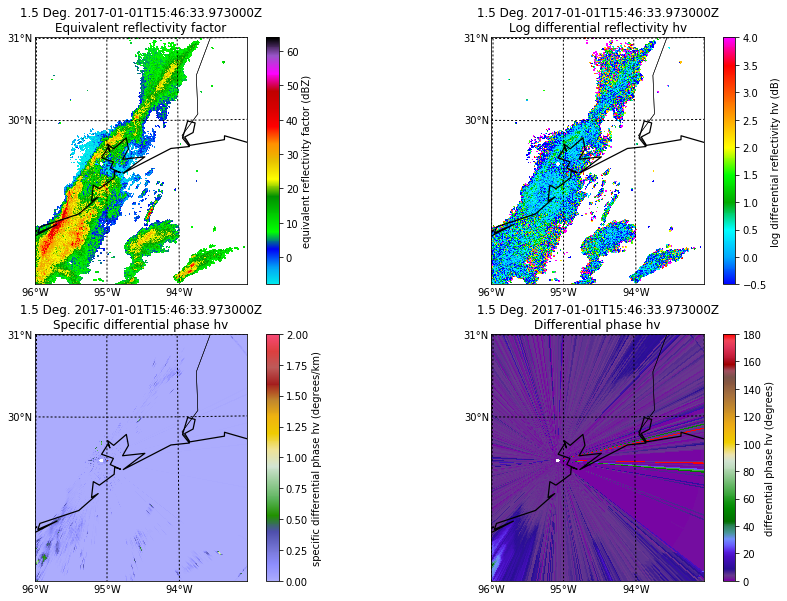

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-19 12:00:41.965271. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [58]:
display = pyart.graph.RadarMapDisplay(radar)
f = plt.figure(figsize = [15,10])
plt.subplot(2, 2, 1)
display.plot_ppi_map('reflectivity', sweep = sw,
                     min_lon = min_lon, max_lon = max_lon,
                     min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', vmin = -8, vmax = 64)
plt.subplot(2, 2, 2)
display.plot_ppi_map('differential_reflectivity', sweep = sw, vmin = -.5, vmax = 4,
                      min_lon = min_lon, max_lon = max_lon,
                      min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l')

plt.subplot(2, 2, 3)
display.plot_ppi_map('specific_differential_phase', sweep = sw, vmin =0, vmax = 2.,
                     min_lon = min_lon, max_lon = max_lon,
                     min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l')
plt.subplot(2, 2, 4)
display.plot_ppi_map('cylp_processed_phase', sweep = sw,
                    vmin = 0, vmax = 180,
                      min_lon = min_lon, max_lon = max_lon,
                      min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.Carbone42)

plt.savefig(os.path.join(im_output_location,
    'multi_'+ymd_string+hms_string+'.png'))


In [69]:
grids = pyart.map.grid_from_radars(radar,(31,801,801),
                   ((0.,15000.),(-200000.,200000.),(-200000.,200000.)),
                   fields=['differential_phase', 'differential_reflectivity', 
                           'cross_correlation_ratio', 'reflectivity', 'unfolded_differential_phase', 
                           'velocity', 'cylp_processed_phase', 'spectrum_width', 
                           'specific_differential_phase'],
                   refl_field='reflectivity',roi_func='dist_beam',
                   h_factor=0.,nb=0.6,bsp=1.,min_radius=200.)  

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-19 12:16:13.835374. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


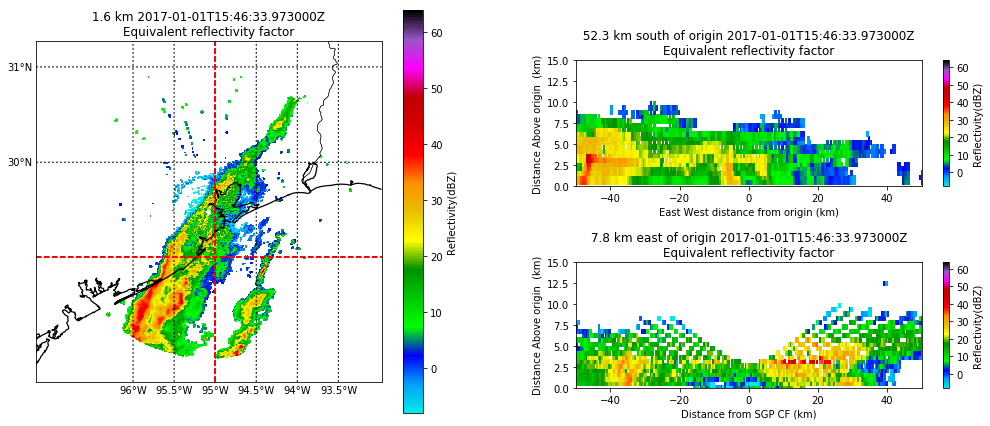

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-19 12:17:05.014528. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [70]:
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[15, 7])

# panel sizes
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

# parameters
level = 3
vmin = -8
vmax = 64
lat = 29
lon = -95

# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = lon_lines, resolution='h' )
display.plot_grid('reflectivity', level=level, vmin=vmin, vmax=vmax,
                 cmap = pyart.graph.cm.NWSRef)
display.plot_crosshairs(lon=lon, lat=lat)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                            cmap = pyart.graph.cm.NWSRef)
ax2.set_ylim([0,15])
ax2.set_xlim([-50,50])
ax2.set_xlabel('Distance from SGP CF (km)')

# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
ax3.set_ylim([0,15])
ax3.set_xlim([-50,50])
display.plot_latitude_slice('reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                           cmap = pyart.graph.cm.NWSRef)
plt.savefig(os.path.join(im_output_location,
    'grid_'+ymd_string+hms_string+'.png'))


In [67]:
r_output_location = os.path.join(odir_data, ymd_string)
if not os.path.exists(r_output_location):
    try:
        os.makedirs(r_output_location)
    except:
        print('looks like it is there! sneaky')

write_qvp_filename = os.path.join(r_output_location,
                                 'KHGX_qvp_'+ymd_string+hms_string+'.txt')

hts = np.linspace(radar.altitude['data'],15000.0 + radar.altitude['data'],61)
flds =['reflectivity',
         'differential_reflectivity',
         'specific_differential_phase',
         'cross_correlation_ratio']
my_qvp = radar_codes.retrieve_qvp(radar, hts, flds = flds)
hts_string = 'height(m) '
for htss in hts:
    hts_string = hts_string + str(int(htss)) + ' '

dis_fh = open(write_qvp_filename, 'w')
dis_fh.write(hts_string + '\n')
for key in flds:
    print(key)
    this_str = key + ' '
    for i in range(len(hts)):
        this_str = this_str + str(my_qvp[key][i]) + ' '
    this_str = this_str + '\n'
    dis_fh.write(this_str)
dis_fh.close()



reflectivity
differential_reflectivity
specific_differential_phase
cross_correlation_ratio


/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-19 12:08:25.543748. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [62]:

rfilename = os.path.join(r_output_location, 'KHGX_sur_' + ymd_string + '.' +  hms_string + '.nc')
pyart.io.write_cfradial(rfilename, radar)
gfilename = os.path.join(r_output_location, 'KHGX_grid_' + ymd_string + '.' +  hms_string + '.nc')
pyart.io.write_grid(gfilename, grids)

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-19 12:03:05.689752. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
